In [ ]:
pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# import libraries

In [ ]:
from pyspark.sql import SparkSession

# initialize spark session

In [ ]:
spark = SparkSession.builder.appName('Youtube Data Analysis - Title Analysis').getOrCreate()

# load the dataset

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/CAvideos.csv'

In [ ]:
df = spark.read.csv(file_path, header=True, inferSchema=True)

# display schema

In [ ]:
df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)
 |-- video_error_or_removed: string (nullable = true)
 |-- description: string (nullable = true)



# preview data

In [ ]:
# no. of rows
df.count()

45560

In [ ]:
# no. of columns
len(df.columns)

16

In [ ]:
df.show()

+-----------+-------------+----------------------+--------------------+-----------+--------------------+------------------------------+--------+-------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|   video_id|trending_date|                 title|       channel_title|category_id|        publish_time|                          tags|   views|  likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|         description|
+-----------+-------------+----------------------+--------------------+-----------+--------------------+------------------------------+--------+-------+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+
|n1WpP7iowLc|     17.14.11|  Eminem - Walk On ...|          EminemVEVO|         10|2017-11-10T17:00:...|          "Eminem"|"Walk"|"...|17158579| 787425|   43420|       1258

# Feature selection

In [ ]:
df = df.drop("trending_date", "thumbnail_link", "comments_disabled", "ratings_disabled", "video_error_or_removed", "description")

In [ ]:
df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: string (nullable = true)



In [ ]:
df.show(5)

+-----------+--------------------+-------------+-----------+--------------------+--------------------+--------+-------+--------+-------------+
|   video_id|               title|channel_title|category_id|        publish_time|                tags|   views|  likes|dislikes|comment_count|
+-----------+--------------------+-------------+-----------+--------------------+--------------------+--------+-------+--------+-------------+
|n1WpP7iowLc|Eminem - Walk On ...|   EminemVEVO|         10|2017-11-10T17:00:...|"Eminem"|"Walk"|"...|17158579| 787425|   43420|       125882|
|0dBIkQ4Mz1M|PLUSH - Bad Unbox...|    iDubbbzTV|         23|2017-11-13T17:00:...|"plush"|"bad unbo...| 1014651| 127794|    1688|        13030|
|5qpjK5DgCt4|Racist Superman |...| Rudy Mancuso|         23|2017-11-12T19:05:...|"racist superman"...| 3191434| 146035|    5339|         8181|
|d380meD0W0M|I Dare You: GOING...|     nigahiga|         24|2017-11-12T18:01:...|"ryan"|"higa"|"hi...| 2095828| 132239|    1989|        17518|

# Data Cleaning

In [ ]:
from pyspark.sql.functions import col, sum, length, lower, split, explode, count, year, to_date

# check for null values

In [ ]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

In [ ]:
null_counts.show()

+--------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+
|video_id|title|channel_title|category_id|publish_time|tags|views|likes|dislikes|comment_count|
+--------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+
|       0| 4177|         4239|       4365|        4418|4580| 4614| 4622|    4622|         4625|
+--------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+



# Remove or Handle Null Values

In [ ]:
df = df.na.fill({'views':0, 'likes':0, 'dislikes':0, 'comment_count':0})

In [ ]:
df.show(5)

+-----------+--------------------+-------------+-----------+--------------------+--------------------+--------+-------+--------+-------------+
|   video_id|               title|channel_title|category_id|        publish_time|                tags|   views|  likes|dislikes|comment_count|
+-----------+--------------------+-------------+-----------+--------------------+--------------------+--------+-------+--------+-------------+
|n1WpP7iowLc|Eminem - Walk On ...|   EminemVEVO|         10|2017-11-10T17:00:...|"Eminem"|"Walk"|"...|17158579| 787425|   43420|       125882|
|0dBIkQ4Mz1M|PLUSH - Bad Unbox...|    iDubbbzTV|         23|2017-11-13T17:00:...|"plush"|"bad unbo...| 1014651| 127794|    1688|        13030|
|5qpjK5DgCt4|Racist Superman |...| Rudy Mancuso|         23|2017-11-12T19:05:...|"racist superman"...| 3191434| 146035|    5339|         8181|
|d380meD0W0M|I Dare You: GOING...|     nigahiga|         24|2017-11-12T18:01:...|"ryan"|"higa"|"hi...| 2095828| 132239|    1989|        17518|

# Check for Duplicate Records

In [ ]:
duplicates = df.groupBy(df.columns).count().filter("count > 1")

In [ ]:
duplicates.show()

+------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|                video_id|               title|       channel_title|         category_id|        publish_time|                tags|               views|               likes|            dislikes|       comment_count|count|
+------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|\n연합뉴스TV : 02-398...|                NULL|                NULL|                NULL|                NULL|                NULL|                   0|                   0|                   0|                   0|    2|
|    \nhttps://www.you...|                NULL|                NULL|                NULL|                NULL|      

In [ ]:
df = df.dropDuplicates()

In [ ]:
df.show(5)

+-----------+--------------------+-----------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+
|   video_id|               title|    channel_title|category_id|        publish_time|                tags|  views|likes|dislikes|comment_count|
+-----------+--------------------+-----------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+
|VsYmwBOYfW8|Mean Tweets – Jim...|Jimmy Kimmel Live|         23|2017-11-14T08:30:...|"jimmy"|"jimmy ki...|2765121|35531|    1705|         2388|
|MMGrzOu1amQ|HOLO CAPPUCCINO |...|Simply Nailogical|         24|2017-11-15T23:08:...|"nails"|"nail art...|1693011|84669|     810|        14183|
|nVTNrp1RuEI|Nicki Minaj's Pap...|   Wendy Williams|         24|2017-11-17T02:00:...|"nicki minaj pape...| 348532| 4246|     918|         2495|
|f4ZJ4Cwk_l0|BREAKING NEWS TRU...|         Shayetet|         24|2017-11-16T12:20:...|"donald trump"|"s...| 138544| 2015|     222|       

In [ ]:
df = df.filter(col('views')<=1000000000)

In [ ]:
df.show(5)

+-----------+--------------------+-----------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+
|   video_id|               title|    channel_title|category_id|        publish_time|                tags|  views|likes|dislikes|comment_count|
+-----------+--------------------+-----------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+
|VsYmwBOYfW8|Mean Tweets – Jim...|Jimmy Kimmel Live|         23|2017-11-14T08:30:...|"jimmy"|"jimmy ki...|2765121|35531|    1705|         2388|
|MMGrzOu1amQ|HOLO CAPPUCCINO |...|Simply Nailogical|         24|2017-11-15T23:08:...|"nails"|"nail art...|1693011|84669|     810|        14183|
|nVTNrp1RuEI|Nicki Minaj's Pap...|   Wendy Williams|         24|2017-11-17T02:00:...|"nicki minaj pape...| 348532| 4246|     918|         2495|
|f4ZJ4Cwk_l0|BREAKING NEWS TRU...|         Shayetet|         24|2017-11-16T12:20:...|"donald trump"|"s...| 138544| 2015|     222|       

# Fill Null Values in Categorical Columns

In [ ]:
categorical_columns = [col_name for col_name, dtype in df.dtypes if dtype == "string"]

In [ ]:
categorical_columns

['video_id',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count']

In [ ]:
from pyspark.sql import functions as F

In [ ]:
for col_name in categorical_columns:
    mode_value = df.groupBy(col_name).count().orderBy(F.desc("count")).first()
    if mode_value and mode_value[0] is not None:  # Check if mode_value and its first element are not None
        df = df.na.fill(mode_value[0], subset=[col_name])  # Fill missing values only if mode_value exists
    else:
        print(f"Warning: No mode found or mode is None for column {col_name}. Skipping imputation.")

In [ ]:
df.show(5)

+-----------+--------------------+-----------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+
|   video_id|               title|    channel_title|category_id|        publish_time|                tags|  views|likes|dislikes|comment_count|
+-----------+--------------------+-----------------+-----------+--------------------+--------------------+-------+-----+--------+-------------+
|VsYmwBOYfW8|Mean Tweets – Jim...|Jimmy Kimmel Live|         23|2017-11-14T08:30:...|"jimmy"|"jimmy ki...|2765121|35531|    1705|         2388|
|MMGrzOu1amQ|HOLO CAPPUCCINO |...|Simply Nailogical|         24|2017-11-15T23:08:...|"nails"|"nail art...|1693011|84669|     810|        14183|
|nVTNrp1RuEI|Nicki Minaj's Pap...|   Wendy Williams|         24|2017-11-17T02:00:...|"nicki minaj pape...| 348532| 4246|     918|         2495|
|f4ZJ4Cwk_l0|BREAKING NEWS TRU...|         Shayetet|         24|2017-11-16T12:20:...|"donald trump"|"s...| 138544| 2015|     222|       

# Verify the Cleaning

In [ ]:
null_counts_categorical = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in categorical_columns])

In [ ]:
null_counts_categorical.show()

+--------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+
|video_id|title|channel_title|category_id|publish_time|tags|views|likes|dislikes|comment_count|
+--------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+
|       0|  615|          638|          0|         698|   0|    0|    0|       0|            0|
+--------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+



# Convert datatypes

In [ ]:
from pyspark.sql.functions import col, to_timestamp, to_date

In [ ]:
# Set the legacy time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [ ]:
df = df.withColumn("publish_time", to_timestamp(col("publish_time"), "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))

In [ ]:
df = df.withColumn("publish_date", to_date(col("publish_time")))

In [ ]:
df.show(5)

+-----------+--------------------+-----------------+-----------+-------------------+--------------------+-------+-----+--------+-------------+------------+
|   video_id|               title|    channel_title|category_id|       publish_time|                tags|  views|likes|dislikes|comment_count|publish_date|
+-----------+--------------------+-----------------+-----------+-------------------+--------------------+-------+-----+--------+-------------+------------+
|VsYmwBOYfW8|Mean Tweets – Jim...|Jimmy Kimmel Live|         23|2017-11-14 08:30:01|"jimmy"|"jimmy ki...|2765121|35531|    1705|         2388|  2017-11-14|
|MMGrzOu1amQ|HOLO CAPPUCCINO |...|Simply Nailogical|         24|2017-11-15 23:08:18|"nails"|"nail art...|1693011|84669|     810|        14183|  2017-11-15|
|nVTNrp1RuEI|Nicki Minaj's Pap...|   Wendy Williams|         24|2017-11-17 02:00:03|"nicki minaj pape...| 348532| 4246|     918|         2495|  2017-11-17|
|f4ZJ4Cwk_l0|BREAKING NEWS TRU...|         Shayetet|         24|

In [ ]:
df = df.drop("publish_time")

In [ ]:
df.printSchema()

root
 |-- video_id: string (nullable = false)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = false)
 |-- tags: string (nullable = false)
 |-- views: string (nullable = false)
 |-- likes: string (nullable = false)
 |-- dislikes: string (nullable = false)
 |-- comment_count: string (nullable = false)
 |-- publish_date: date (nullable = true)



In [ ]:
df.show(5)

+-----------+--------------------+-----------------+-----------+--------------------+-------+-----+--------+-------------+------------+
|   video_id|               title|    channel_title|category_id|                tags|  views|likes|dislikes|comment_count|publish_date|
+-----------+--------------------+-----------------+-----------+--------------------+-------+-----+--------+-------------+------------+
|VsYmwBOYfW8|Mean Tweets – Jim...|Jimmy Kimmel Live|         23|"jimmy"|"jimmy ki...|2765121|35531|    1705|         2388|  2017-11-14|
|MMGrzOu1amQ|HOLO CAPPUCCINO |...|Simply Nailogical|         24|"nails"|"nail art...|1693011|84669|     810|        14183|  2017-11-15|
|nVTNrp1RuEI|Nicki Minaj's Pap...|   Wendy Williams|         24|"nicki minaj pape...| 348532| 4246|     918|         2495|  2017-11-17|
|f4ZJ4Cwk_l0|BREAKING NEWS TRU...|         Shayetet|         24|"donald trump"|"s...| 138544| 2015|     222|          662|  2017-11-16|
|YE0qGSCuHK8|JUST IN: The FBI ...|  Trey Gowdy N

In [ ]:
from pyspark.sql.types import IntegerType

In [ ]:
# Convert 'views', 'likes', 'dislikes', and 'comment_count' to integer type (optional)
df = df.withColumn("views", col("views").cast(IntegerType()))
df = df.withColumn("likes", col("likes").cast(IntegerType()))
df = df.withColumn("dislikes", col("dislikes").cast(IntegerType()))
df = df.withColumn("comment_count", col("comment_count").cast(IntegerType()))

In [ ]:
df.printSchema()

root
 |-- video_id: string (nullable = false)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = false)
 |-- tags: string (nullable = false)
 |-- views: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- publish_date: date (nullable = true)



# Title Length Analysis

### Calculate Title Length

In [ ]:
from pyspark.sql.functions import length, col

In [ ]:
# Calculate the length of each title
df = df.withColumn("title_length", length(col("title")))

In [ ]:
# Show the first few rows to verify
df.select("title", "title_length").show(truncate=False)

+----------------------------------------------------------------------------------------------+------------+
|title                                                                                         |title_length|
+----------------------------------------------------------------------------------------------+------------+
|Mean Tweets – Jimmy Kimmel Edition                                                            |34          |
|HOLO CAPPUCCINO | DIY Diamond Cappuccino test (maybe don't drink this?)                       |71          |
|Nicki Minaj's Paper Magazine Cover                                                            |34          |
|BREAKING NEWS TRUMP 11/16/17: Hillary Clinton's email probe special status                    |74          |
|JUST IN: The FBI drops MAJOR BOMBSHELL on URANIUM ONE that will put Hillary Clinton on the run|94          |
|Miranda Sings Hijacks a Stranger's Tinder | Vanity Fair                                       |55          |
|Our NASCA

### Summary Statistics

In [ ]:
from pyspark.sql.functions import mean, stddev, min, max

In [ ]:
df.describe("title_length").show()

+-------+------------------+
|summary|      title_length|
+-------+------------------+
|  count|             41051|
|   mean|53.636330418260215|
| stddev|22.681826030509566|
|    min|                 1|
|    max|               875|
+-------+------------------+



In [ ]:
df.agg(
    mean("title_length").alias("mean_length"),
    stddev("title_length").alias("stddev_length"),
    min("title_length").alias("min_length"),
    max("title_length").alias("max_length")
).show()

+------------------+------------------+----------+----------+
|       mean_length|     stddev_length|min_length|max_length|
+------------------+------------------+----------+----------+
|53.636330418260215|22.681826030509566|         1|       875|
+------------------+------------------+----------+----------+



### Distribution Visualization

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
pandas_df = df.select("title_length").toPandas()

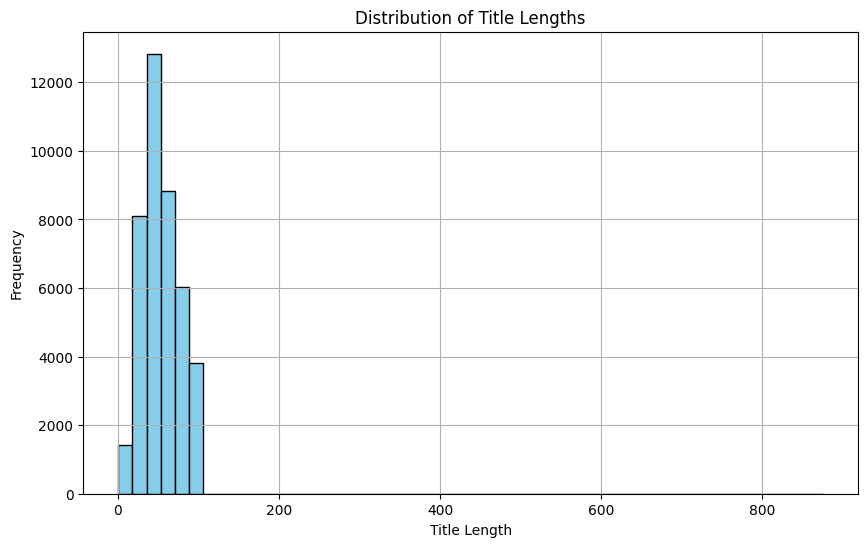

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(pandas_df["title_length"], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Title Lengths")
plt.xlabel("Title Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Box Plot for Title Length

In [ ]:
import seaborn as sns

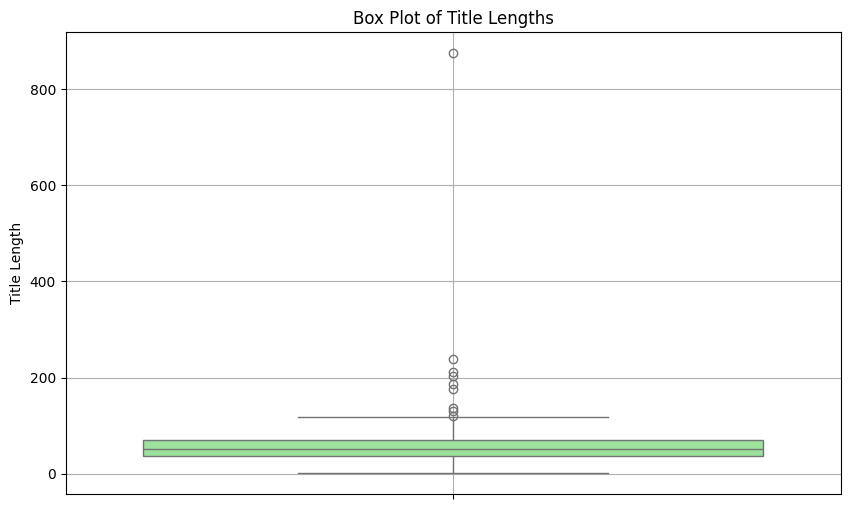

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=pandas_df["title_length"], color='lightgreen')
plt.title("Box Plot of Title Lengths")
plt.ylabel("Title Length")
plt.grid(True)
plt.show()

### Length Distribution by Category

In [ ]:
from pyspark.sql.functions import avg

In [ ]:
df.groupBy("category_id").agg(
    avg("title_length").alias("average_title_length")
).orderBy("average_title_length", ascending=False).show()

+--------------------+--------------------+
|         category_id|average_title_length|
+--------------------+--------------------+
| and his staffer’...|               238.0|
| influential and ...|               176.0|
|                  30|                96.0|
| plucked from a b...|                96.0|
| affection and so...|                91.0|
| and Sarah Sander...|                79.0|
|                  19|    70.8265306122449|
| confident and ed...|                69.0|
|                  17|   67.62719770362396|
| informed reporti...|                63.0|
|                  25|   62.24933878336139|
| even Lara can’t ...|                58.0|
|                  10|   57.74108818011257|
|                  29|  57.729729729729726|
|                  24|   54.58691630281951|
| and in select te...|                54.0|
|                   1|  51.803883495145634|
|                   2|  50.303116147308785|
|                  26|  50.143996013951174|
|                  22|  49.25213

### Title Length Correlation with Other Metrics

In [ ]:
from pyspark.sql.functions import col

In [ ]:
df = df.withColumn("views", col("views").cast("integer"))

In [ ]:
correlation = df.stat.corr("title_length", "views")

In [ ]:
print(f"Correlation between title length and views: {correlation}")

Correlation between title length and views: 0.00016259581444938535


### Visualize Title Length vs. Other Metrics

In [ ]:
pandas_df = df.select("title_length", "views").toPandas()

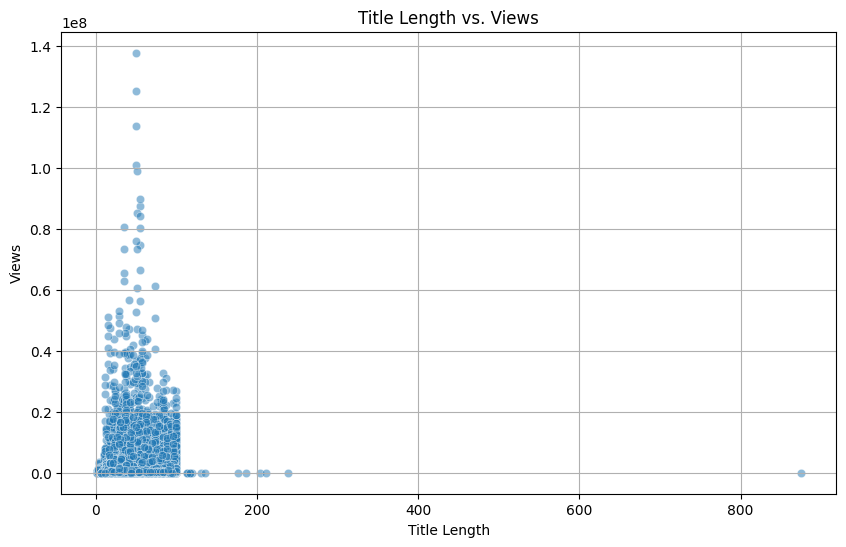

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="title_length", y="views", data=pandas_df, alpha=0.5)
plt.title("Title Length vs. Views")
plt.xlabel("Title Length")
plt.ylabel("Views")
plt.grid(True)
plt.show()

### Title Length by Date

In [ ]:
from pyspark.sql.functions import year, month

In [ ]:
df = df.withColumn("year", year(col("publish_date")))
df = df.withColumn("month", month(col("publish_date")))

In [ ]:
# Calculate average title length by year and month
df.groupBy("year", "month").agg(
    avg("title_length").alias("average_title_length")
).orderBy("year", "month").show()

+----+-----+--------------------+
|year|month|average_title_length|
+----+-----+--------------------+
|NULL| NULL|   36.10588235294118|
|2008|    1|                39.0|
|2008|    2|                 7.0|
|2009|    2|                64.0|
|2010|    1|                13.0|
|2012|   12|                44.0|
|2013|    3|                38.0|
|2013|    5|  57.333333333333336|
|2013|    7|                35.0|
|2013|   11|                53.0|
|2014|    1|                35.5|
|2014|    2|                17.0|
|2014|    9|                49.0|
|2014|   11|                45.0|
|2014|   12|                75.0|
|2015|    4|                57.0|
|2015|    7|                59.0|
|2015|    9|                47.0|
|2015|   10|                51.0|
|2015|   12|                61.0|
+----+-----+--------------------+
only showing top 20 rows



### Length Distribution by Channel

In [ ]:
# Calculate average title length by channel
df.groupBy("channel_title").agg(
    avg("title_length").alias("average_title_length")
).orderBy("average_title_length", ascending=False).show()

+--------------------+--------------------+
|       channel_title|average_title_length|
+--------------------+--------------------+
| including Trump’...|               238.0|
| wife and a son. ...|               204.0|
| immature and boy...|               176.0|
| who has develope...|               136.0|
|                NULL|   118.8695652173913|
|    Hollywood To You|               100.0|
|        MissDeep MIX|               100.0|
|             Le Labo|               100.0|
|BalajiMotionPictures|               100.0|
|           GoLeafsGo|               100.0|
|RealNewsNetworkMedia|               100.0|
|               HYPEX|               100.0|
|       Dwayne N Jazz|               100.0|
|       Kidd In Me TV|               100.0|
|Celebrity News Today|               100.0|
|        chumacprachu|               100.0|
|        Rama Krishna|               100.0|
|             Kill'em|               100.0|
|Devotees Insanos ...|               100.0|
|              spence|          

### Advanced Text Analysis: N-grams
Analyze n-grams (bigrams, trigrams) in titles to understand common phrases.

In [ ]:
from pyspark.ml.feature import NGram, Tokenizer

In [ ]:
# Tokenize titles
tokenizer = Tokenizer(inputCol="title", outputCol="words")
df = tokenizer.transform(df)

In [ ]:
# Create bigrams
ngram = NGram(n=2, inputCol="words", outputCol="bigrams")
df = ngram.transform(df)

In [ ]:
# Extract bigrams
df.select("bigrams").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|bigrams                                                                                                                                                                                               |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[mean tweets, tweets –, – jimmy, jimmy kimmel, kimmel edition]                                                                                                                                        |
|[holo cappuccino, cappuccino |, | diy, diy diamond, diamond cappuccino, cappuccino test, test (maybe, (maybe don't, don't drink, drink this?)]                                                     

### Frequency Analysis of Title Lengths

In [ ]:
# Count occurrences of each title length
df.groupBy("title_length").count().orderBy("title_length").show()

+------------+-----+
|title_length|count|
+------------+-----+
|        NULL|  615|
|           1|    5|
|           2|    5|
|           3|   12|
|           4|    9|
|           5|    6|
|           6|   14|
|           7|   62|
|           8|   24|
|           9|   38|
|          10|   41|
|          11|   67|
|          12|   47|
|          13|  124|
|          14|  102|
|          15|  149|
|          16|  149|
|          17|  226|
|          18|  351|
|          19|  363|
+------------+-----+
only showing top 20 rows



In [ ]:
df.printSchema()

root
 |-- video_id: string (nullable = false)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = false)
 |-- tags: string (nullable = false)
 |-- views: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- publish_date: date (nullable = true)
 |-- title_length: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- words: string (nullable = true)
 |-- bigrams: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col, when, isnull

In [ ]:
df = df.fillna({'words': '', 'bigrams': ''})

In [ ]:
# Convert the 'words' column to a string representation
df = df.withColumn("words", when(isnull(col("words")), "").otherwise(col("words").cast("string")))

In [ ]:
df.select([count(when(isnull(col("words")), True)).alias("null_words_count")]).show()

+----------------+
|null_words_count|
+----------------+
|               0|
+----------------+



In [ ]:
df = df.withColumn("bigrams", col("bigrams").cast("string"))

In [ ]:
df.select([count(when(isnull(col("bigrams")), True)).alias("null_bigrams_count")]).show()

+------------------+
|null_bigrams_count|
+------------------+
|                 0|
+------------------+



# Word Frequency Analysis

In [ ]:
# drop rows with null titles
df = df.filter(col("title").isNotNull())

In [ ]:
# filter out empty titles
df = df.filter(col("title") != "")

### Tokenization

In [ ]:
from pyspark.ml.feature import Tokenizer

In [ ]:
# Tokenize the titles into words
tokenizer = Tokenizer(inputCol="title", outputCol="tokenized_words")
df = tokenizer.transform(df)

In [ ]:
# Show the tokenized words
df.select("title", "tokenized_words").show(truncate=False)

+----------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|title                                                                                         |tokenized_words                                                                                                  |
+----------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|Mean Tweets – Jimmy Kimmel Edition                                                            |[mean, tweets, –, jimmy, kimmel, edition]                                                                        |
|HOLO CAPPUCCINO | DIY Diamond Cappuccino test (maybe don't drink this?)                       |[holo, cappuccino, |, diy, diamond, cappuccino, test, (maybe

### Remove Stop Words

In [ ]:
from pyspark.ml.feature import StopWordsRemover

In [ ]:
# Remove stop words from the tokens
remover = StopWordsRemover(inputCol="title_into_words", outputCol="no_stopwords")
df = remover.transform(df)

In [ ]:
# Show the filtered words
df.select("title", "no_stopwords").show(truncate=False)

+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+
|title                                                                                         |no_stopwords                                                                                          |
+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+
|Mean Tweets – Jimmy Kimmel Edition                                                            |[mean, tweets, –, jimmy, kimmel, edition]                                                             |
|HOLO CAPPUCCINO | DIY Diamond Cappuccino test (maybe don't drink this?)                       |[holo, cappuccino, |, diy, diamond, cappuccino, test, (maybe, drink, this?)]                          |


### Explode the Words Array

In [ ]:
from pyspark.sql.functions import explode, col

In [ ]:
# Explode the array of words into individual rows
df_exploded = df.withColumn("word", explode(when(~isnull(col("filtered_words")), col("filtered_words"))))

In [ ]:
# Show the exploded words
df_exploded.select("word").show(truncate=False)

+----------+
|word      |
+----------+
|mean      |
|tweets    |
|–         |
|jimmy     |
|kimmel    |
|edition   |
|holo      |
|cappuccino|
||         |
|diy       |
|diamond   |
|cappuccino|
|test      |
|(maybe    |
|drink     |
|this?)    |
|nicki     |
|minaj's   |
|paper     |
|magazine  |
+----------+
only showing top 20 rows



In [ ]:
df_exploded = df_exploded.filter(col("word").isNotNull())

### Count Word Frequencies

In [ ]:
word_freq_df = df_exploded.groupBy("word").count()

In [ ]:
print(word_freq_df.columns)

['word', 'count']


In [ ]:
word_freq_df.printSchema()

root
 |-- word: string (nullable = true)
 |-- count: long (nullable = false)



In [ ]:
word_freq_df.show(10, truncate=True)

+---------+-----+
|     word|count|
+---------+-----+
|   crokin|    2|
|    anime|   37|
|     man)|   10|
|   travel|   32|
|     guts|   34|
|      ...|   40|
|    still|   47|
|connected|    9|
|     hope|   20|
|   metal)|    3|
+---------+-----+
only showing top 10 rows



In [ ]:
# Convert to Pandas DataFrame
word_freq_pd = word_freq_df.toPandas()

In [ ]:
print(word_freq_pd.head(10))

        word  count
0     crokin      2
1      anime     37
2       man)     10
3     travel     32
4       guts     34
5        ...     40
6      still     47
7  connected      9
8       hope     20
9     metal)      3


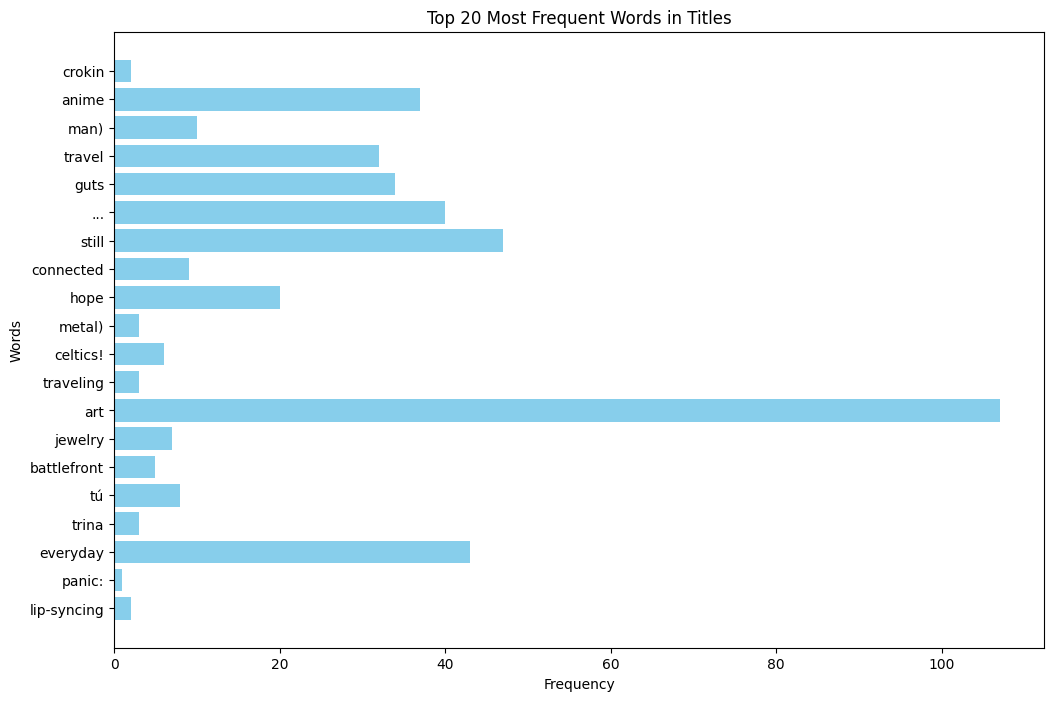

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(word_freq_pd["word"][:20][::-1], word_freq_pd["count"][:20][::-1], color='skyblue')
plt.title("Top 20 Most Frequent Words in Titles")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

### Phrase (N-gram) Analysis

In [ ]:
from pyspark.ml.feature import NGram

In [ ]:
# Create bigrams (two-word phrases)
ngram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams_2_word_phrases")
df_bigrams = ngram.transform(df)

In [ ]:
# Explode the bigrams into individual rows
df_bigrams_exploded = df_bigrams.withColumn("bigram", explode(col("bigrams_2_word_phrases")))

In [ ]:
# Count the frequency of each bigram
bigram_freq_df = df_bigrams_exploded.groupBy("bigram").count().orderBy("count", ascending=False)

In [ ]:
# Show the most frequent bigrams
bigram_freq_df.show(truncate=False)

+----------------+-----+
|bigram          |count|
+----------------+-----+
|- full          |549  |
|2018 |          |506  |
|official trailer|439  |
|full episode    |432  |
|(official video)|423  |
|- episode       |411  |
|episode -       |397  |
|game highlights |376  |
|- ep            |370  |
|latest punjabi  |363  |
|| latest        |356  |
|2018 -          |355  |
|full game       |324  |
|- official      |312  |
|songs 2018      |285  |
|music video)    |277  |
|punjabi songs   |276  |
|-               |257  |
|top 10          |256  |
|logan paul      |234  |
+----------------+-----+
only showing top 20 rows



In [ ]:
bigram_freq_pd = bigram_freq_df.toPandas()

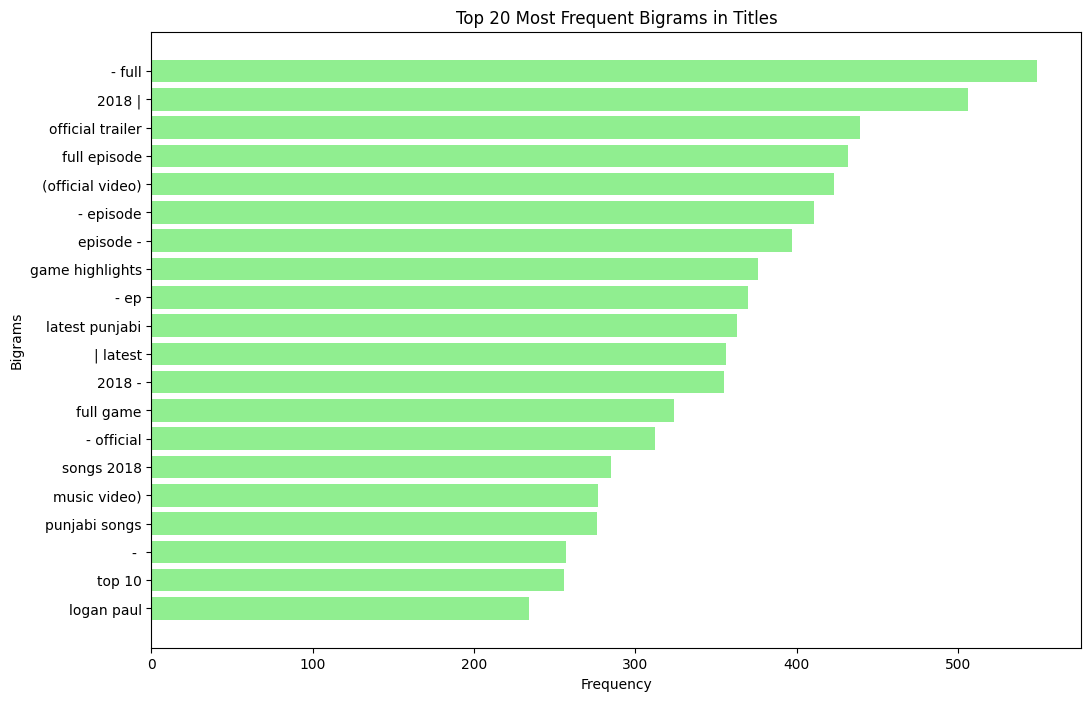

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(bigram_freq_pd["bigram"][:20][::-1], bigram_freq_pd["count"][:20][::-1], color='lightgreen')
plt.title("Top 20 Most Frequent Bigrams in Titles")
plt.xlabel("Frequency")
plt.ylabel("Bigrams")
plt.show()

# Tag Analysis

### Tokenization and Explode Tags

In [ ]:
from pyspark.sql.functions import split, explode, col

In [ ]:
# Tokenize the tags into individual tags (assuming tags are comma-separated)
df = df.withColumn("tag_list", split(col("tags"), "\\|"))

In [ ]:
# Explode the tags into individual rows
df_exploded_tags = df.withColumn("tag", explode(col("tag_list")))

In [ ]:
# Show the exploded tags
df_exploded_tags.select("title", "tag", "views", "likes", "dislikes", "comment_count").show(5, truncate=False)

+----------------------------------+-------------------+-------+-----+--------+-------------+
|title                             |tag                |views  |likes|dislikes|comment_count|
+----------------------------------+-------------------+-------+-----+--------+-------------+
|Mean Tweets – Jimmy Kimmel Edition|"jimmy"            |2765121|35531|1705    |2388         |
|Mean Tweets – Jimmy Kimmel Edition|"jimmy kimmel"     |2765121|35531|1705    |2388         |
|Mean Tweets – Jimmy Kimmel Edition|"jimmy kimmel live"|2765121|35531|1705    |2388         |
|Mean Tweets – Jimmy Kimmel Edition|"late night"       |2765121|35531|1705    |2388         |
|Mean Tweets – Jimmy Kimmel Edition|"talk show"        |2765121|35531|1705    |2388         |
+----------------------------------+-------------------+-------+-----+--------+-------------+
only showing top 5 rows



### Calculate Average Views, Likes, Dislikes, and Comments per Tag

In [ ]:
tag_impact_df = df_exploded_tags.groupBy("tag") \
    .agg(
        {'views': 'avg', 'likes': 'avg', 'dislikes': 'avg', 'comment_count': 'avg'}
    ) \
    .withColumnRenamed("avg(views)", "avg_views") \
    .withColumnRenamed("avg(likes)", "avg_likes") \
    .withColumnRenamed("avg(dislikes)", "avg_dislikes") \
    .withColumnRenamed("avg(comment_count)", "avg_comments") \
    .orderBy("avg_views", ascending=False)

In [ ]:
# Show the impact of tags
tag_impact_df.show(truncate=False)

+-------------------+------------------+-----------------+--------------------+------------------+
|tag                |avg_comments      |avg_dislikes     |avg_views           |avg_likes         |
+-------------------+------------------+-----------------+--------------------+------------------+
|"April the Giraffe"|726816.1428571428 |1209737.142857143|9.020404785714285E7 |2383993.0         |
|"I’m the One"      |726816.1428571428 |1209737.142857143|9.020404785714285E7 |2383993.0         |
|"HolaSoyGerman"    |579115.2222222222 |944844.3333333334|7.066672877777778E7 |1906058.0         |
|"FAKE_LOVE"        |1036514.75        |145723.0         |7.059842375E7       |4799634.0         |
|"Niana Guerrero"   |509107.1          |846873.2         |6.32022995E7        |1672561.4         |
|"Shape of you"     |509107.1          |846873.2         |6.32022995E7        |1672561.4         |
|"Rhett Link"       |509107.1          |846873.2         |6.32022995E7        |1672561.4         |
|"Joey Gra

### Correlate Tags with Titles

In [ ]:
from pyspark.sql.functions import count, desc

In [ ]:
# Count occurrences of each tag with titles
tag_title_df = df_exploded_tags.groupBy("tag", "title") \
    .agg(count("*").alias("title_count")) \
    .orderBy(desc("title_count"))

In [ ]:
# Show the correlation of tags with titles
tag_title_df.show(truncate=False)

+--------------------------------------------------+-------------------------------------------------------------------------------------------------+-----------+
|tag                                               |title                                                                                            |title_count|
+--------------------------------------------------+-------------------------------------------------------------------------------------------------+-----------+
|[none]                                            | videos                                                                                          |46         |
|[none]                                            | innovation                                                                                      |22         |
|"Instrumental Violin Covers 2"                    |Most Popular Violin Covers of Popular Songs 2018 || Best Instrumental Violin Covers 2018         |15         |
|"Violin Covers 2018" 

In [ ]:
tag_impact_pd = tag_impact_df.toPandas()

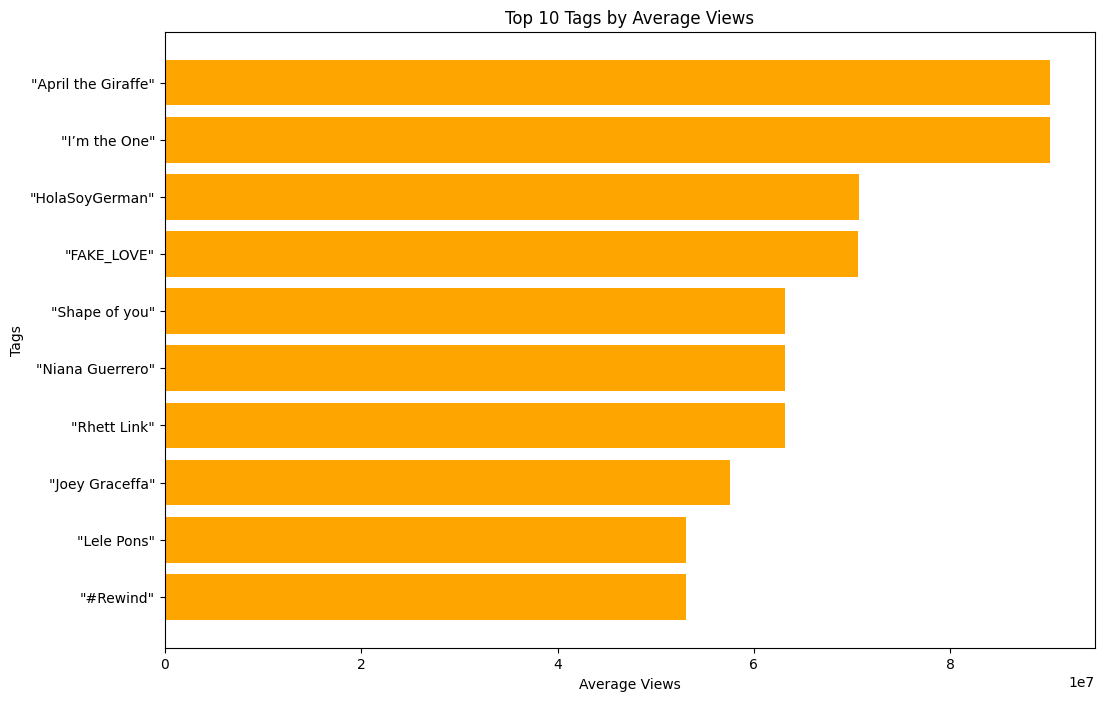

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(tag_impact_pd["tag"][:10][::-1], tag_impact_pd["avg_views"][:10][::-1], color='orange')
plt.title("Top 10 Tags by Average Views")
plt.xlabel("Average Views")
plt.ylabel("Tags")
plt.show()

### Correlation Between Tags and Views

In [ ]:
from pyspark.sql.functions import corr

In [ ]:
# Calculate correlation between tags and views
tag_correlation_df = df_exploded_tags.groupBy("tag") \
    .agg(
        corr("views", "likes").alias("correlation_views_likes"),
        corr("views", "dislikes").alias("correlation_views_dislikes"),
        corr("views", "comment_count").alias("correlation_views_comments")
    )

In [ ]:
# Show the correlation
tag_correlation_df.show(truncate=False)

+---------------------------+-----------------------+--------------------------+--------------------------+
|tag                        |correlation_views_likes|correlation_views_dislikes|correlation_views_comments|
+---------------------------+-----------------------+--------------------------+--------------------------+
|"diy cappuccino"           |1.0                    |1.0                       |1.0                       |
|"hijacks dating account"   |0.7986084058185491     |0.5132108165688911        |0.8450040554037996        |
|"deiva magal serial"       |0.8031064583395799     |0.35908590741121754       |0.7137665788774205        |
|"wolfie song"              |0.947431337985314      |0.9891318824331798        |0.9196686788396866        |
|"dr phil"                  |0.9706215876947726     |0.9728188143402501        |0.9386771855246023        |
|"laboratory"               |0.999714267952127      |0.9988924835618629        |0.9997940692384687        |
|"Drama"                    

# Stemming

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

In [ ]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

In [ ]:
# Define a UDF for stemming
def stem_words(words):
    return [stemmer.stem(word) for word in words]

In [ ]:
# Register the UDF
stem_udf = udf(stem_words, ArrayType(StringType()))

In [ ]:
# Apply stemming to the filtered words
df_stemmed = df.withColumn("stemmed_words", stem_udf(col("filtered_words")))

In [ ]:
# Show the stemmed words
df_stemmed.select("title", "stemmed_words").show(truncate=False)

+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|title                                                                                         |stemmed_words                                                                                   |
+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|Mean Tweets – Jimmy Kimmel Edition                                                            |[mean, tweet, –, jimmi, kimmel, edit]                                                           |
|HOLO CAPPUCCINO | DIY Diamond Cappuccino test (maybe don't drink this?)                       |[holo, cappuccino, |, diy, diamond, cappuccino, test, (mayb, drink, this?)]                     |
|Nicki Minaj's Paper Magazine 

# Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
# Define a UDF for lemmatization
def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

In [ ]:
# Register the UDF
lemmatize_udf = udf(lemmatize_words, ArrayType(StringType()))

In [ ]:
# Apply lemmatization to the filtered words
df_lemmatized = df.withColumn("lemmatized_words", lemmatize_udf(col("filtered_words")))

In [ ]:
# Show the lemmatized words
df_lemmatized.select("title", "lemmatized_words").show(truncate=False)

+----------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|title                                                                                         |lemmatized_words                                                                                    |
+----------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|Mean Tweets – Jimmy Kimmel Edition                                                            |[mean, tweet, –, jimmy, kimmel, edition]                                                            |
|HOLO CAPPUCCINO | DIY Diamond Cappuccino test (maybe don't drink this?)                       |[holo, cappuccino, |, diy, diamond, cappuccino, test, (maybe, drink, this?)]                        |
|Nicki Min

# Sentiment Analysis

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [ ]:
# Download the VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

### Define a UDF for Sentiment Analysis

In [ ]:
# Define a UDF to apply sentiment scoring
def get_sentiment_score(title):
    sentiment_score = sia.polarity_scores(title)
    compound_score = sentiment_score['compound']

    # Determine sentiment as positive, negative, or neutral based on compound score
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
# Register the UDF
sentiment_udf = udf(get_sentiment_score, StringType())

In [ ]:
# Apply sentiment analysis to the titles
df_sentiment = df.withColumn("sentiment", sentiment_udf(col("title")))

In [ ]:
# Show the titles with their corresponding sentiment
df_sentiment.select("title", "sentiment").show(truncate=False)

+----------------------------------------------------------------------------------------------+---------+
|title                                                                                         |sentiment|
+----------------------------------------------------------------------------------------------+---------+
|Mean Tweets – Jimmy Kimmel Edition                                                            |neutral  |
|HOLO CAPPUCCINO | DIY Diamond Cappuccino test (maybe don't drink this?)                       |positive |
|Nicki Minaj's Paper Magazine Cover                                                            |neutral  |
|BREAKING NEWS TRUMP 11/16/17: Hillary Clinton's email probe special status                    |positive |
|JUST IN: The FBI drops MAJOR BOMBSHELL on URANIUM ONE that will put Hillary Clinton on the run|neutral  |
|Miranda Sings Hijacks a Stranger's Tinder | Vanity Fair                                       |positive |
|Our NASCAR Caught On Fire During The

### Analyze the Sentiment Distribution

In [ ]:
# Group by sentiment and count the occurrences
sentiment_distribution_df = df_sentiment.groupBy("sentiment").count()

In [ ]:
# Show the sentiment distribution
sentiment_distribution_df.show(truncate=False)

+---------+-----+
|sentiment|count|
+---------+-----+
|positive |8822 |
|neutral  |23623|
|negative |8606 |
+---------+-----+



In [ ]:
sentiment_distribution_pd = sentiment_distribution_df.toPandas()

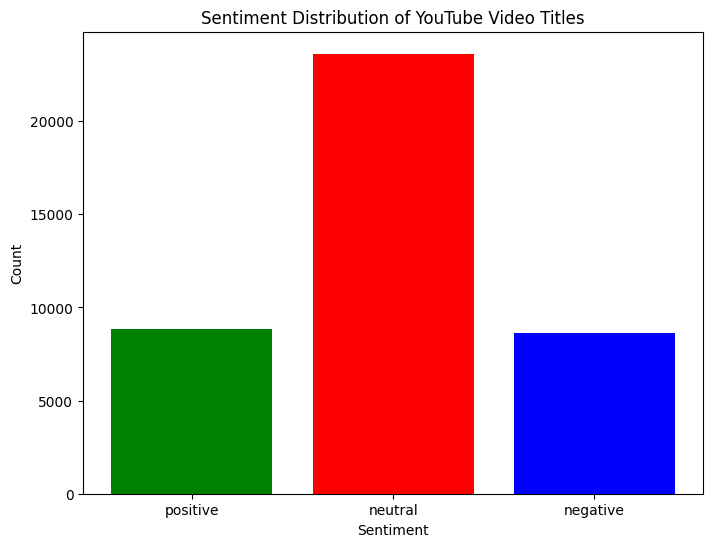

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(sentiment_distribution_pd["sentiment"], sentiment_distribution_pd["count"], color=['green', 'red', 'blue'])
plt.title("Sentiment Distribution of YouTube Video Titles")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Keyword Analysis

### Keyword Extraction Using TF-IDF

In [ ]:
from pyspark.ml.feature import HashingTF, IDF

In [ ]:
# Compute term frequencies
hashingTF = HashingTF(inputCol="tokenized_words", outputCol="raw_features", numFeatures=20)
df_tf = hashingTF.transform(df)

In [ ]:
# Compute the IDF (Inverse Document Frequency)
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(df_tf)
df_tfidf = idfModel.transform(df_tf)

In [ ]:
# Show the resulting TF-IDF scores
df_tfidf.select("title", "features").show(truncate=False)

+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                                         |features                                                                                                                                                                                                                                                                |
+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Topic Modeling Using LDA (Latent Dirichlet Allocation)

In [ ]:
from pyspark.ml.clustering import LDA

In [ ]:
# Set up the LDA model
lda = LDA(k=5, maxIter=10, featuresCol="features")

In [ ]:
# Fit the LDA model
lda_model = lda.fit(df_tfidf)

In [ ]:
# Transform the data to get topic distribution
df_lda = lda_model.transform(df_tfidf)

In [ ]:
# Show the topic distribution for each title
df_lda.select("title", "topicDistribution").show(truncate=False)

+----------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------+
|title                                                                                         |topicDistribution                                                                                       |
+----------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------+
|Mean Tweets – Jimmy Kimmel Edition                                                            |[0.02674091394100899,0.4514424140094819,0.026723182451660502,0.026836107512657987,0.4682573820851906]   |
|HOLO CAPPUCCINO | DIY Diamond Cappuccino test (maybe don't drink this?)                       |[0.015765014875237432,0.01548176506799378,0.015748682484120785,0.015782708738710797,0.9372218288

### Extracting Topics

In [ ]:
# Describe topics (get top 10 words for each topic)
topics = lda_model.describeTopics(10)

In [ ]:
# Show the topics and their corresponding words
topics.show(truncate=False)

+-----+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                          |termWeights                                                                                                                                                                                                         |
+-----+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[10, 0, 5, 11, 14, 12, 9, 8, 17, 6]  |[0.11831321281675256, 0.11529292271518277, 0.1019631210542, 0.06564324164914138, 0.0629912697875147, 0.050591886335235516, 0.04939019933056894, 0.046214443449908896, 0.0426479468

# Correlation Analysis

### Views vs. Title Length Correlation

In [ ]:
from pyspark.sql.functions import length, col

In [ ]:
# Add a new column with the length of each title
df_with_length = df.withColumn("title_length", length(col("title")))

In [ ]:
# Calculate Title Length
df_with_length.select("title", "title_length", "views").show(truncate=False)

+----------------------------------------------------------------------------------------------+------------+-------+
|title                                                                                         |title_length|views  |
+----------------------------------------------------------------------------------------------+------------+-------+
|Mean Tweets – Jimmy Kimmel Edition                                                            |34          |2765121|
|HOLO CAPPUCCINO | DIY Diamond Cappuccino test (maybe don't drink this?)                       |71          |1693011|
|Nicki Minaj's Paper Magazine Cover                                                            |34          |348532 |
|BREAKING NEWS TRUMP 11/16/17: Hillary Clinton's email probe special status                    |74          |138544 |
|JUST IN: The FBI drops MAJOR BOMBSHELL on URANIUM ONE that will put Hillary Clinton on the run|94          |115938 |
|Miranda Sings Hijacks a Stranger's Tinder | Vanity Fair

In [ ]:
from pyspark.sql.types import IntegerType

In [ ]:
# Convert the views column to integer type
df_with_length = df_with_length.withColumn("views", col("views").cast(IntegerType()))

In [ ]:
# Show the DataFrame with title length and views
df_with_length.select("title_length", "views").show()

+------------+-------+
|title_length|  views|
+------------+-------+
|          34|2765121|
|          71|1693011|
|          34| 348532|
|          74| 138544|
|          94| 115938|
|          55| 679693|
|          56| 901202|
|          31|  55086|
|          90| 363164|
|          44| 348848|
|          38|  31431|
|          17| 752058|
|          33| 816868|
|          17| 320476|
|          92|3763835|
|          45| 597163|
|          43| 154285|
|          42|3853829|
|          35| 701137|
|          58|  65364|
+------------+-------+
only showing top 20 rows



In [ ]:
# Calculate correlation between title length and views
correlation = df_with_length.stat.corr("title_length", "views")

In [ ]:
print(f"Correlation between title length and views: {correlation}")

Correlation between title length and views: -0.011610577161594833


In [ ]:
df_pandas = df_with_length.select("title_length", "views").toPandas()

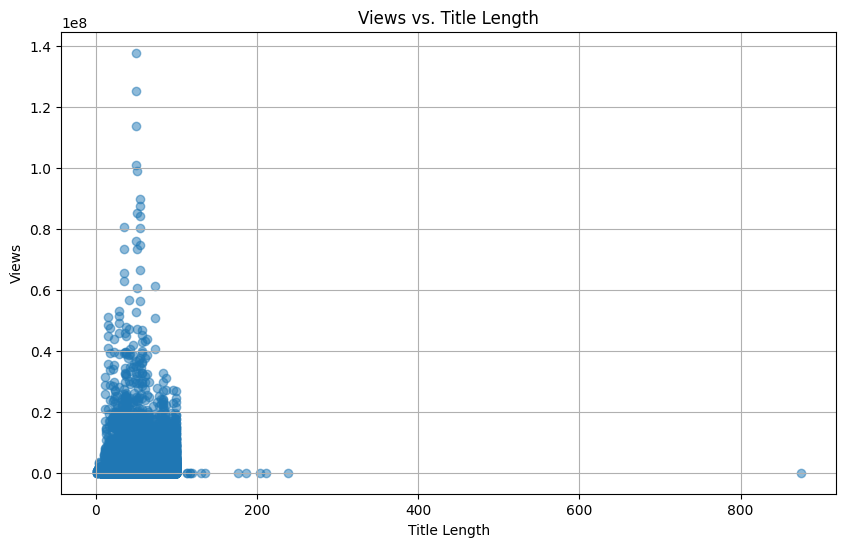

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_pandas['title_length'], df_pandas['views'], alpha=0.5)
plt.title('Views vs. Title Length')
plt.xlabel('Title Length')
plt.ylabel('Views')
plt.grid(True)
plt.show()

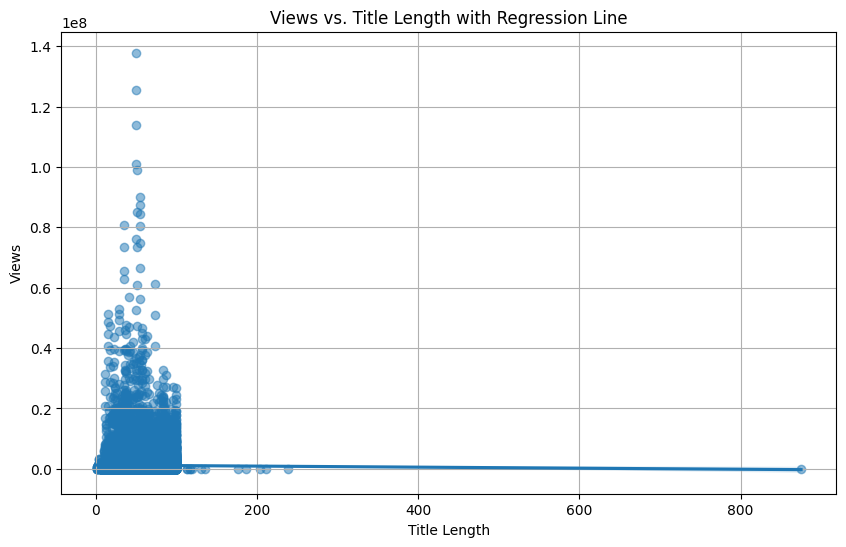

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='title_length', y='views', data=df_pandas, scatter_kws={'alpha':0.5})
plt.title('Views vs. Title Length with Regression Line')
plt.xlabel('Title Length')
plt.ylabel('Views')
plt.grid(True)
plt.show()

### Likes/Dislikes vs. Keywords Correlation

In [ ]:
# Convert likes and dislikes columns to integer type
df_with_likes_dislikes = df.withColumn("likes", col("likes").cast(IntegerType()))
df_with_likes_dislikes = df_with_likes_dislikes.withColumn("dislikes", col("dislikes").cast(IntegerType()))

### Analyze Correlation for Specific Keywords

In [ ]:
from pyspark.sql.functions import when

In [ ]:
# Example: Analyze correlation with keyword "review"
keyword = "review"

In [ ]:
df_with_keywords = df.withColumn("has_review", when(col("title").contains("review"), 1).otherwise(0))

In [ ]:
# Calculate correlation with likes
correlation_likes = df_with_keywords.stat.corr("has_review", "likes")
print(f"Correlation between 'review' keyword and likes: {correlation_likes}")

Correlation between 'review' keyword and likes: -0.009665887378884814


In [ ]:
# Calculate correlation with dislikes
correlation_dislikes = df_with_keywords.stat.corr("has_review", "dislikes")

In [ ]:
print(f"Correlation between 'review' keyword and dislikes: {correlation_dislikes}")

Correlation between 'review' keyword and dislikes: -0.003479294163689216


In [ ]:
df_keywords_pd = df_with_keywords.select("has_review", "likes", "dislikes").toPandas()

In [ ]:
# Group by keyword presence and calculate mean likes/dislikes
mean_values = df_keywords_pd.groupby("has_review").mean()

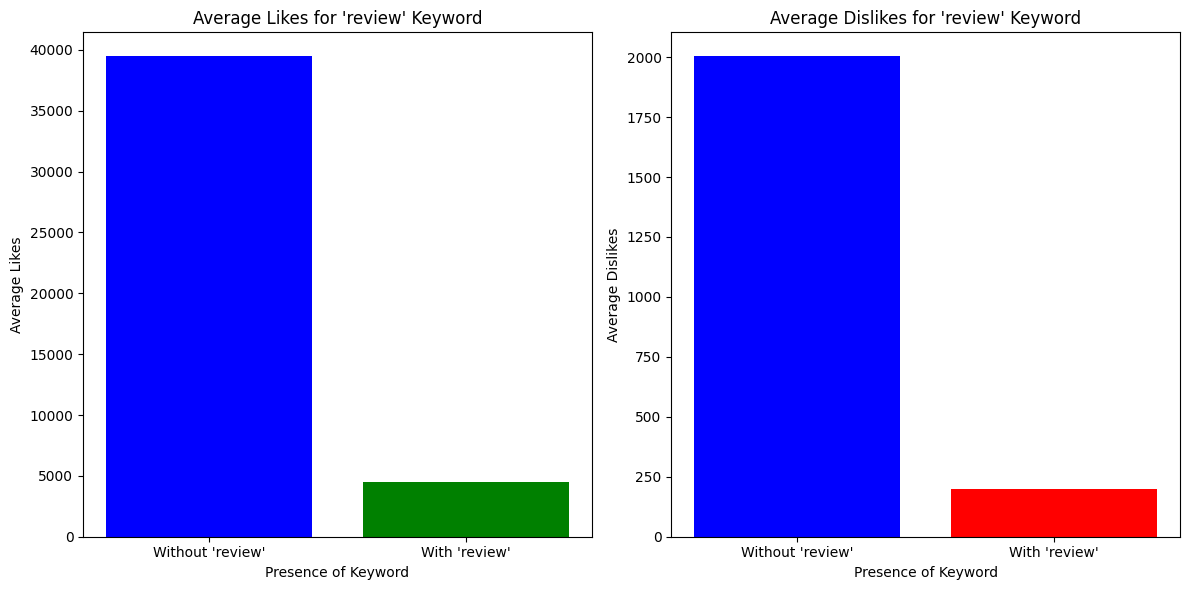

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(["Without 'review'", "With 'review'"], mean_values["likes"], color=['blue', 'green'])
ax[0].set_title(f"Average Likes for '{keyword}' Keyword")
ax[0].set_xlabel('Presence of Keyword')
ax[0].set_ylabel('Average Likes')

ax[1].bar(["Without 'review'", "With 'review'"], mean_values["dislikes"], color=['blue', 'red'])
ax[1].set_title(f"Average Dislikes for '{keyword}' Keyword")
ax[1].set_xlabel('Presence of Keyword')
ax[1].set_ylabel('Average Dislikes')

plt.tight_layout()
plt.show()

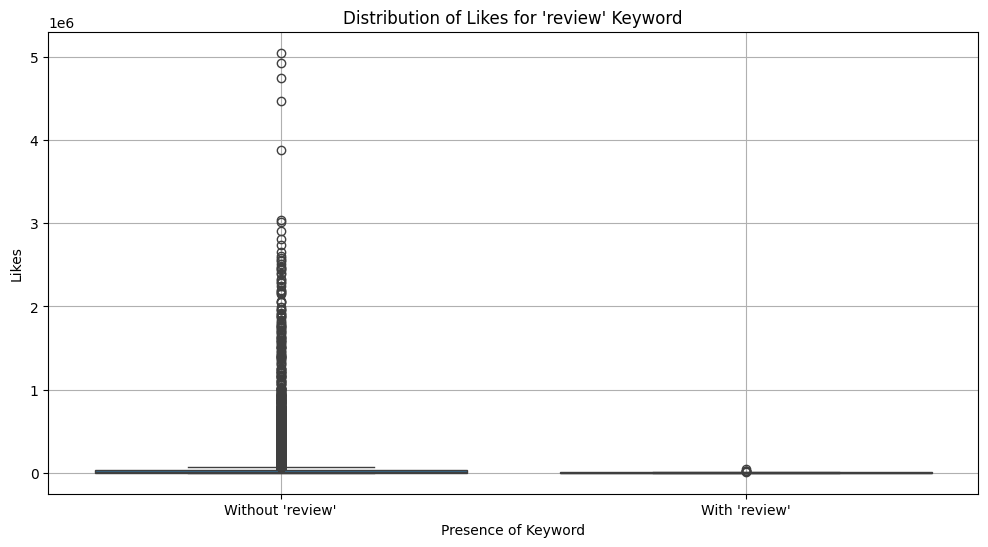

In [ ]:
# Box plot for likes
plt.figure(figsize=(12, 6))
sns.boxplot(x="has_review", y="likes", data=df_keywords_pandas)
plt.title(f"Distribution of Likes for '{keyword}' Keyword")
plt.xlabel("Presence of Keyword")
plt.ylabel("Likes")
plt.xticks([0, 1], ["Without 'review'", "With 'review'"])
plt.grid(True)
plt.show()

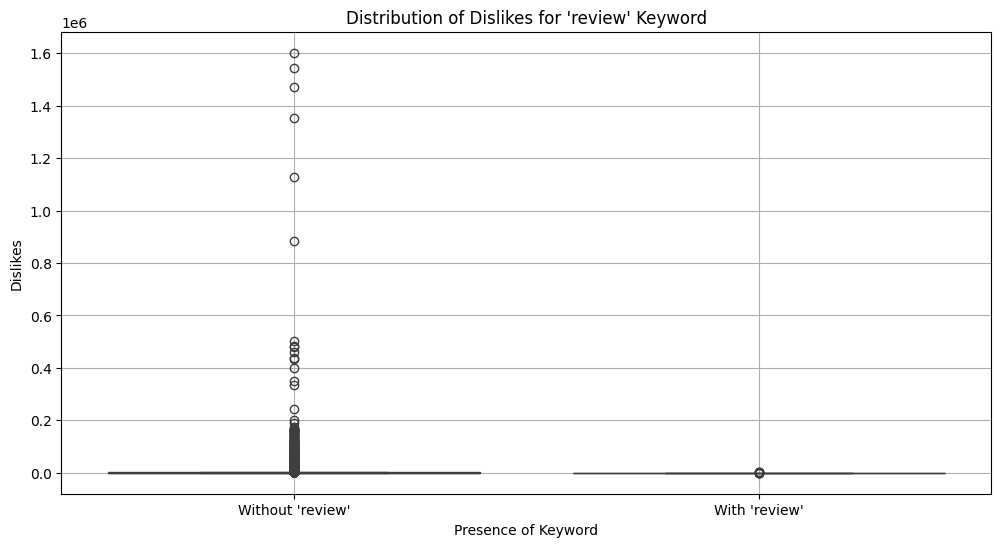

In [ ]:
# Box plot for dislikes
plt.figure(figsize=(12, 6))
sns.boxplot(x="has_review", y="dislikes", data=df_keywords_pandas)
plt.title(f"Distribution of Dislikes for '{keyword}' Keyword")
plt.xlabel("Presence of Keyword")
plt.ylabel("Dislikes")
plt.xticks([0, 1], ["Without 'review'", "With 'review'"])
plt.grid(True)
plt.show()

# Visualization

### Word Cloud

In [ ]:
pip install wordcloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Assuming you have the word frequency DataFrame `word_freq_pd` from previous analysis
word_freq_dict = dict(zip(word_freq_pd['word'], word_freq_pd['count']))

In [ ]:
# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

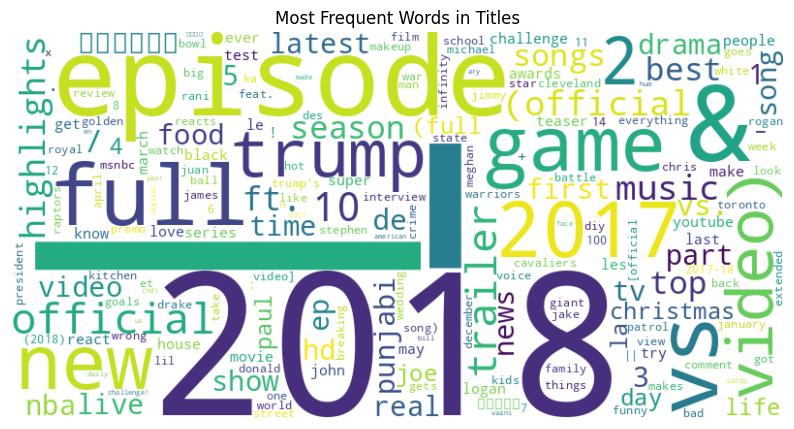

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Most Frequent Words in Titles')
plt.show()

### Bar Chart for Title Length Distribution

In [ ]:
df_pandas = df_with_length.select("title_length").toPandas()

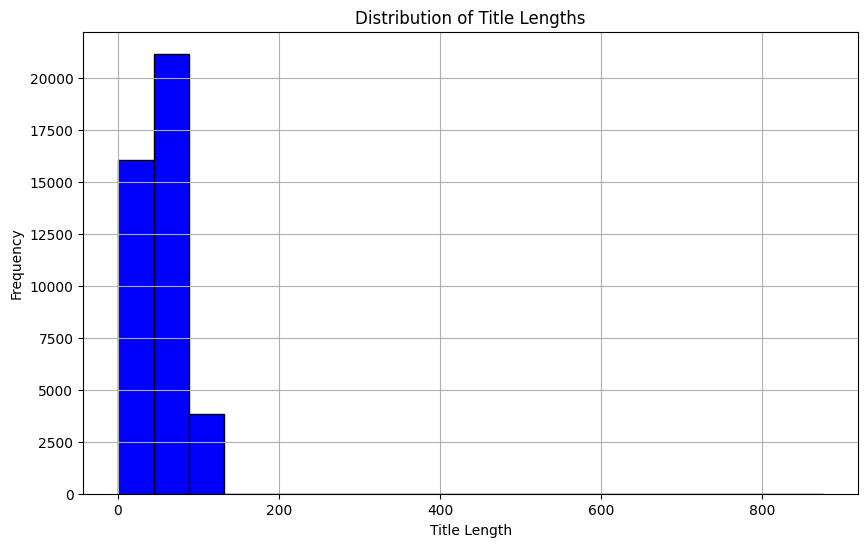

In [ ]:
plt.figure(figsize=(10, 6))
df_pandas['title_length'].plot(kind='hist', bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Bar Chart for Keyword Frequencies

<Figure size 1200x800 with 0 Axes>

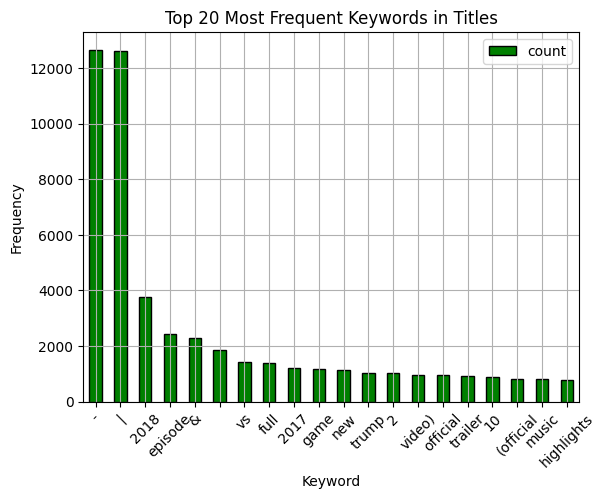

In [ ]:
plt.figure(figsize=(12, 8))
word_freq_pd.sort_values(by='count', ascending=False).head(20).plot(kind='bar', x='word', y='count', color='green', edgecolor='black')
plt.title('Top 20 Most Frequent Keywords in Titles')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()